
MC for correlation  0.7
Finished generating sample paths
Calculating Option Price and Implied Vols of F(t)
Completed Calculation of Implied Volatilities

MC for correlation  0.8
Finished generating sample paths
Calculating Option Price and Implied Vols of F(t)
Completed Calculation of Implied Volatilities

MC for correlation  0.9
Finished generating sample paths
Calculating Option Price and Implied Vols of F(t)
Completed Calculation of Implied Volatilities

MC for correlation  1
Finished generating sample paths
Calculating Option Price and Implied Vols of F(t)
Completed Calculation of Implied Volatilities


Calculating Option Price and Implied Vols of L(t)
Completed Calculation of Implied Volatilities


Text(0, 0.5, 'Implied Volaility')

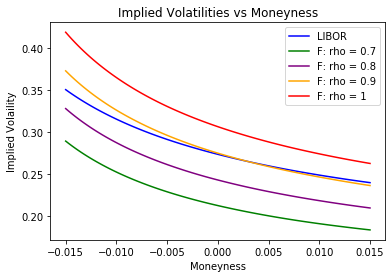

In [66]:
#import packages here
import numpy as np
import pandas as pd

from scipy.stats import norm

def NormPdf(X):
    return np.exp(-0.5*(X**2))/np.sqrt(2*np.pi)

#Black Scholes Option Pricing Formula
def BlackScholes(S,K,v):
    return S * norm.cdf((np.log(S/K)+0.5*v*v)/v) - K * norm.cdf((np.log(S/K)-0.5*v*v)/v)
#define Example Problem Parameters

T = 10
L0 = 0.03
F0 = 0.027
sigma = 0.1
alpha = 0.05
rho = [0.7,0.8,0.9,1]


# define Stochastic Process for L and F

def LStoch(L_t,dW):
    return sigma*(L_t+alpha)*dW
 
def FStoch(L_t,dW,r):
    return r*sigma*(L_t+alpha)*dW

from scipy.optimize import fsolve

#Function to solve for Implied Volatility
def SolveVol(sigmaK,S0,K,t,CT):     ## CT - Option Price calculated by MC
    return CT - BlackScholes(S0,K,sigmaK*np.sqrt(t))


#Specify Parameters for MC Simulation
ImpliedVols = {}      # Dictionary to hold the Implied Vols for different rho
NPaths = 300000       # Num of Simulation Paths
dt = 0.1              # time increment

for cor in rho:
    print('\nMC for correlation ',cor)
    n=1
    Lt = np.full((NPaths),L0)      ## Initialize L(t) and F(t) to L0 and F0
    Ft = np.full((NPaths),F0) 
    moneyness = np.linspace(-0.015,0.015,100)    
    
    while n <= T/dt:            ##Loop through time
        
        ##Generate correlated Std Brownian Motion for L and F
        dWL = np.random.normal(0, np.sqrt(dt), NPaths)      
        dWF = cor * dWL + np.sqrt(1 - cor **2) * np.random.normal(0, np.sqrt(dt), NPaths)

        ## Compute and update the Trajectory of L and F for this period
        Ltemp = Lt + 0                          
        Lt = Lt + LStoch(Ltemp,dWL)
        Ft = Ft + FStoch(Ltemp,dWF,cor)
        n = n+1
    
    print('Finished generating sample paths')
    print('Calculating Option Price and Implied Vols of F(t)')
    K = F0 + moneyness        ## Generate Strike Prices for index F(t) 
    FVols = []                ## Store Computed Implied Volatilities here

    for k in K:
        #Calculate the pay off of each Path of F(t)
        Payoff = [max(s-k,0) for s in Ft]     
        #Undiscounted Option Price -> Mean value of Payoffs
        OptionPrice = np.mean(Payoff)      
        ##Solve BS to find Implied Vol
        FVols.append(fsolve(SolveVol,0.4,args=(F0,k,T,OptionPrice))) 
        
    print('Completed Calculation of Implied Volatilities')
    ImpliedVols[cor] = FVols    ##Update to main Dict

print('\n')
print('Calculating Option Price and Implied Vols of L(t)')
K = L0 + moneyness        ## Generate Strike Prices for index L(t) 
LVols = []                ## Store Computed Implied Volatilities here
for k in K:
    
    #Calculate the pay off of each Path of L(t)
    Payoff = [max(s-k,0) for s in Lt]     
    OptionPrice = np.mean(Payoff)        #Undiscounted Option Price -> Mean value of Payoffs
    LVols.append(fsolve(SolveVol,0.4,args=(L0,k,T,OptionPrice))) ##Solve BS to find Implied Vol
    
print('Completed Calculation of Implied Volatilities')


import matplotlib.pyplot as plt
plt.plot(moneyness,LVols,label='LIBOR',color='blue')
plt.plot(moneyness,ImpliedVols[0.7],label='F: rho = 0.7',color='green')
plt.plot(moneyness,ImpliedVols[0.8],label='F: rho = 0.8',color='purple')
plt.plot(moneyness,ImpliedVols[0.9],label='F: rho = 0.9',color='orange')
plt.plot(moneyness,ImpliedVols[1],label='F: rho = 1',color='red')
plt.legend()
plt.title('Implied Volatilities vs Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Implied Volaility')